# Optimal Transport for Two Marginals

TODO: theory

## Sinkhorn Algorithm

Find the desired measure
$$\Pi_{i,j} = a(x) K(x,y) b(y)$$
where
$$a(x) = \exp \left\{ \frac{u(x)}{\varepsilon} \right\}$$
$$b(y) = \exp \left\{ \frac{v(y)}{\varepsilon} \right\}$$
$$K(x, y) = \exp \left\{ - \frac{c(x, y)}{\varepsilon} \right\}$$

For the discrete case:
$$\Pi_{i,j} = a_{i} K_{i,j} b_{j}$$

where $a_{i}, K_{i,j}$ and $b_{j}$ are matrices.


TODO: input data

TODO: output data

TODO: complexity?

1. Initialize $a^{0} \equiv 1$
2. Update the 

In [1]:
import torch

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.transforms as transforms

In [125]:
def plot_discrete_ot_solution(P, p, q, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize, layout=None, facecolor='#cfcfcf')
    gs = fig.add_gridspec(nrows=2, ncols=2, left=0.15, right=0.85,
                        hspace=0.1, wspace=0.05,
                        width_ratios=[0.8, 0.2], height_ratios=[0.2, 0.8])
    
    matrix_size = P.size()
    big_matrix = matrix_size[0] * matrix_size[1] >= 60 # heuristic threshold for annotation readability
    
    # Create histogram for p
    ax0 = fig.add_subplot(gs[0, 0])
    ax0_x = np.arange(len(q))
    ax0_y = q.numpy().flatten()
    ax0.bar(ax0_x, ax0_y, width=1.0, align='edge', color='blue', alpha=0.5)
    if not big_matrix:
        ax0.axis('off')
        ax0_max_y = ax0_y.max()
        for i, val in enumerate(ax0_y):
            ax0.text(i + .5, val + ax0_max_y*.1, f"{val:.2f}", color="black", ha="center", va="bottom")
    else:
        ax0.grid()

    # Create histogram for q
    ax1 = fig.add_subplot(gs[1, 1])
    ax1_x = np.arange(len(p))
    ax1_y = p.numpy().flatten()[::-1]
    ax1.barh(ax1_x, ax1_y, height=1.0, align='edge', color='red', alpha=0.5)
    if not big_matrix:
        ax1.axis('off')
        ax1_max_y = ax1_y.max()
        for i, val in enumerate(ax1_y):
            ax1.text(val + ax1_max_y*.1, i + .5, f"{val:.2f}", color="black", ha="left", va="center")
    else:
        ax1.grid()

    customColormap = ListedColormap(['#003f5c','#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600'])
    
    ax2 = fig.add_subplot(gs[1, 0])
    cax = ax2.matshow(P, cmap=customColormap if not big_matrix else 'viridis')
    # Annotating the matrix elements if they are large enough
    if not big_matrix:  
        for i in range(matrix_size[0]):
            for j in range(matrix_size[1]):
                ax2.text(j, i, str(round(P.numpy()[i, j], 4)), va='center', ha='center', color='white')
    
    ax2.set_xlabel('Target Distribution (q)')
    ax2.set_ylabel('Source Distribution (p)')

    fig.suptitle('Discrete OT with regularization')


In [126]:
def sinkhorn(C, p, q, epsilon, max_iters=1000, stop_threshold=1e-9):
    """
    Sinkhorn algorithm for regularized optimal transport using PyTorch.
    
    Args:
        C (torch.Tensor): Cost matrix of shape (N, M).
        p (torch.Tensor): Source distribution of shape (N, 1).
        q (torch.Tensor): Target distribution of shape (M, 1).
        epsilon (float): Regularization parameter.
        max_iters (int): Maximum number of iterations.
        stop_threshold (float): Convergence threshold.
    
    Returns:
        torch.Tensor: Regularized transport plan of shape (N, M).
    """

    # Compute the kernel matrix
    K = torch.exp(-C / epsilon)
    K_transpose = K.t()

    # Initialize scaling vectors
    a = torch.ones_like(p)

    # Sinkhorn iterations
    for _ in range(max_iters):
        b = q / (K_transpose @ a)
        a = p / (K @ b)
        
        # Check for convergence
        # if torch.max(torch.abs(a - prev_a)) < stop_threshold:
        #     break
        # prev_a = a

    # Compute the transport plan
    a_expanded = a.expand_as(K)
    b_expanded = b.t().expand_as(K)
    P = a_expanded * K * b_expanded
    
    return P


In [127]:
p = torch.tensor([[0.3], [0.6], [0.1]])
q = torch.tensor([[0.2], [0.2], [0.6]])
c = torch.tensor([
    [1., 2., 2.],
    [2., 1., 1.],
    [3., 1., 2.],
])


P_prime = sinkhorn(c, p, q, 1/3)

In [128]:
def check_transport_plan(P_prime, p, q, precision=1e-3, log=False):
    predicates = [
        (torch.sum(P_prime, dim=0) - torch.squeeze(q) < precision).numpy().all(),
        (torch.sum(P_prime, dim=1) - torch.squeeze(p) < precision).numpy().all(),
    ]
    if log:
        print('The sum of the transport plan matrix is:', torch.sum(P_prime).item())
        print('The solution preserves mass for q:', torch.sum(P_prime, dim=0) - torch.squeeze(q) < precision)
        print('The solution mass difference for q is:', (torch.sum(P_prime, dim=0) - torch.squeeze(q)).numpy())
        print('The solutions preserves mass for p:', torch.sum(P_prime, dim=1).numpy())
        print('The solution preserves mass for p:', torch.sum(P_prime, dim=1) - torch.squeeze(p) < precision)
        print('The solution mass difference for p is:', (torch.sum(P_prime, dim=1) - torch.squeeze(p)).numpy())
    return all(predicates)

In [129]:
check_transport_plan(P_prime, p, q, precision=1e-5, log=True)

The sum of the transport plan matrix is: 1.0000001192092896
The solution preserves mass for q: tensor([True, True, True])
The solution mass difference for q is: [0. 0. 0.]
The solutions preserves mass for p: [0.3        0.6000001  0.09999999]
The solution preserves mass for p: tensor([True, True, True])
The solution mass difference for p is: [ 0.0000000e+00  5.9604645e-08 -7.4505806e-09]


True

In [130]:
P_prime

tensor([[1.9706e-01, 1.7580e-02, 8.5365e-02],
        [2.8334e-03, 1.0198e-01, 4.9519e-01],
        [1.1128e-04, 8.0441e-02, 1.9447e-02]])

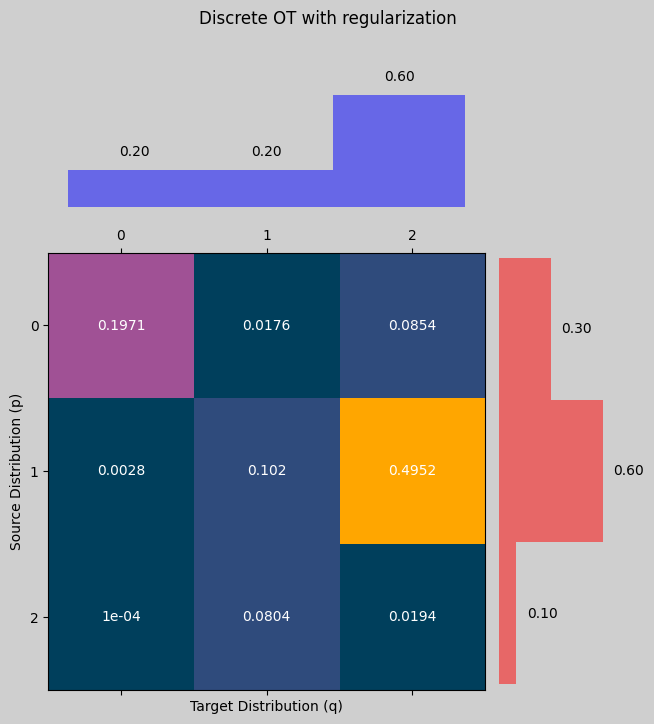

In [131]:
plot_discrete_ot_solution(P_prime, p, q)

In [132]:
def generate_sinkhorn_problem(num_sources, num_targets, dist='manhattan'):
    """
    Generates a random problem instance for the Sinkhorn algorithm.

    Args:
        num_sources (int): Number of points in the source distribution.
        num_targets (int): Number of points in the target distribution.

    Returns:
        C (torch.Tensor): Cost matrix of shape (num_sources, num_targets).
        p (torch.Tensor): Source distribution of shape (num_sources, 1).
        q (torch.Tensor): Target distribution of shape (num_targets, 1).
    """
    match dist:
        case 'manhattan':
            source_points = torch.linspace(0, 1, steps=num_sources).unsqueeze(1)
            target_points = torch.linspace(0, 1, steps=num_targets).unsqueeze(1)
            C = torch.cdist(source_points, target_points, p=1)
        case 'random':
            # Generate a random cost matrix
            C = torch.rand(num_sources, num_targets)

    # Generate random distributions such that they sum to 1
    p = torch.rand(num_sources, 1)
    p = p / p.sum()

    q = torch.rand(num_targets, 1)
    q = q / q.sum()

    return C, p, q

Generated the problem:
Vector p: tensor([[9.0648e-03],
        [9.4011e-03],
        [3.9337e-03],
        [9.8563e-03],
        [4.0116e-03],
        [6.1738e-03],
        [2.6361e-03],
        [8.1542e-03],
        [9.6659e-03],
        [1.3684e-03],
        [9.6024e-03],
        [6.0987e-03],
        [8.9326e-03],
        [5.8329e-03],
        [7.6143e-03],
        [4.4119e-03],
        [9.0974e-03],
        [5.8965e-03],
        [2.7389e-03],
        [6.4467e-03],
        [2.7703e-03],
        [4.5347e-03],
        [3.0507e-03],
        [8.5451e-03],
        [1.0820e-03],
        [2.7689e-03],
        [3.6866e-03],
        [2.0483e-03],
        [5.6221e-03],
        [6.3295e-05],
        [9.7766e-03],
        [7.7331e-04],
        [9.1033e-03],
        [5.9921e-03],
        [3.4691e-03],
        [8.3117e-03],
        [5.9378e-03],
        [9.2879e-03],
        [5.6988e-03],
        [3.5171e-03],
        [6.5175e-03],
        [3.7441e-03],
        [7.2992e-03],
        [9.7238e-03],

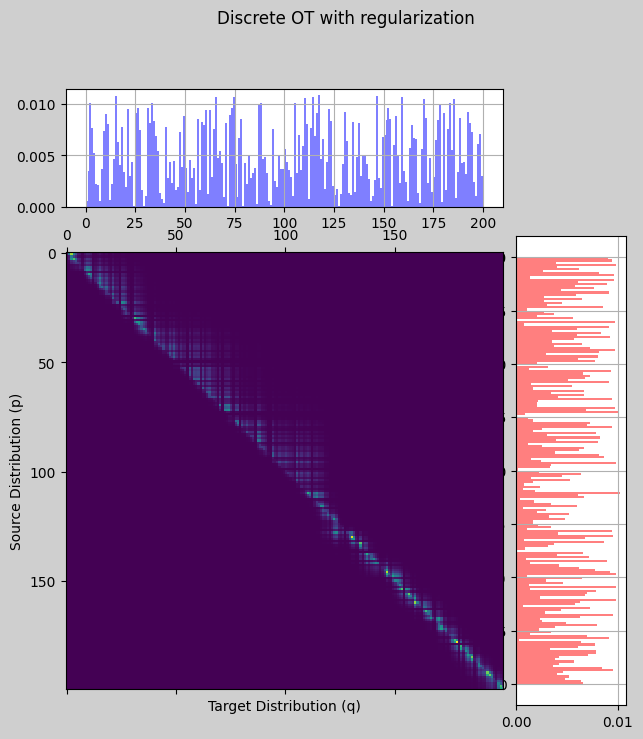

In [139]:
torch.manual_seed(42)

n = 200
C, p, q = generate_sinkhorn_problem(n, n)

print('Generated the problem:')
print('Vector p:', p)
print('Vector q:', q)

eps = .01
P_prime = sinkhorn(C, p, q, epsilon=eps)

print('The solution:', P_prime)

print('Is the solution ok? --', check_transport_plan(P_prime, p, q))

plot_discrete_ot_solution(P_prime, p, q)